# Importing modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, classification_report

# Import Data Frame

In [2]:
columnsWine = ["WineID", "Alcohol", "MalicAcid", "Ash", "AlcalinityOfAsh", "Magnesium", "TotalPhenols", 
               "Flavanoids", "NonflavanoidPhenols","Proanthocyanins", "ColorIntensity", "Hue", "OD280/OD315", "Proline"]

df = pd.read_csv(r"C:\Users\Cristofer Becerra S\Documents\Tec de Monterrey\7mo Semestre\Datasets\wine.data", 
                 names = columnsWine)

In [3]:
df.head()

,WineID,Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,Flavanoids,NonflavanoidPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Preprocessing data for the Neural Network

In [4]:
le = LabelEncoder()
scaler = StandardScaler()
minmax = MinMaxScaler()

In [5]:
x = minmax.fit_transform(df.drop(columns = "WineID"))
y = le.fit_transform(df.WineID)

# Train-validate-test split

In [6]:
rs, rsData = 0, 0
x1, x_test, y1, y_test = train_test_split(x, y, train_size = 0.8, random_state = rsData)
x_train, x_validate, y_train, y_validate = train_test_split(x1, y1, train_size = 0.7, random_state = rsData)

# Neural Network Comparison

We will compare the performance of two neural networks with a fixed set of epochs (50).

In [7]:
epochs = 50

# Simple NN

First we build a simple neural network. Let a simple neural network have 1 hidden layer with 2 neurons, optimized by *regular* Stochastic Gradient Descent (SGD) using a sigmoid activation function, a constant learning rate of 0.001.

In [8]:
simpleNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (2,), learning_rate = "adaptive", 
                         learning_rate_init = 0.01, max_iter = epochs)

We can train and overview its performance by a simple mean accuracy score for both training and test datasets.

In [9]:
simpleNN.fit(x_train, y_train)
print("Training score: ", round(simpleNN.score(x_train, y_train), 4))
print("Validate score: ", round(simpleNN.score(x_validate, y_validate), 4))
print("Test score: ", round(simpleNN.score(x_test, y_test), 4))

Training score:  0.8053
Validate score:  0.8276
Test score:  0.7778


C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


It's evident that this model performs poorly with the given resctrictions (epochs) due to the simplicity of its structure. Perhaps given more epochs it would perform much better.

In [10]:
del simpleNN

# Optimized NN

We can perform a rudimentary optimization of the parameters of the network. This can be done using Scikit-learn's GridSearch algorithm for exhaustive search of the best model using different combinations passed to it.

## Simple Grid Search Optimization

In [11]:
from sklearn.model_selection import GridSearchCV

Since Adaptive Moment Estimation SGD is an optimizer of the simple SGD, we can reduce the combinations by only employing the optimized version of SGD. Also, given the functionality of Scikit-learn and the fact that adaptive learning rate is almost always better than constant, we will also reduce the parameters by only using adaptive learning rates.

In [12]:
hyperparameters = {'activation': ['relu'], 
                   'hidden_layer_sizes': [(2,), (4,), (8,), (16,), (64,), 
                                          (2,2,), (4,2), (2,4), (8,2), (2,8), (8,4), (4,8),
                                         (2,2,2), (4,2,2), (2,4,2), (4,2,4), (4,8,2), (4,8,4), (8,8,8)],
                   'alpha': [0.0001, 0.0005, 0.001, 0.01],
                   'learning_rate_init': [0.001, 0.01, 0.1],
                   'learning_rate': ['adaptive'],
                   'solver': ['adam']}

**DANGER**: this is an intensive CPU cell; it took my i5-825U @ 1.80GHz about 6.55 minutes to run. Do not run this cell if your computer isn't very capable or if you're running it in Google Colab (it'll truly take forever). You've been warned.

In [13]:
nn = MLPClassifier(random_state = rs, max_iter = epochs)

hps = GridSearchCV(nn, hyperparameters, n_jobs = -1, cv = 5) # hyper-parameter search

hps.fit(x_train, y_train);

bestH = hps.best_params_

SearchResults = pd.DataFrame(hps.cv_results_)
SearchResults = SearchResults.sort_values("rank_test_score", ascending = True)
SearchResults.head()

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
113,0.113292,0.021602,0.002805,0.002486,relu,0.0005,"(8, 8, 8)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.956522,0.956522,1.000000,1.0,1.0,0.982609,0.021300,1
227,0.087583,0.002612,0.000797,0.000398,relu,0.01,"(8, 8, 8)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.956522,0.956522,1.000000,1.0,1.0,0.982609,0.021300,1
197,0.071990,0.001644,0.000798,0.000399,relu,0.01,"(8, 2)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.956522,1.000000,0.913043,1.0,1.0,0.973913,0.034783,3
140,0.080656,0.015624,0.000797,0.000746,relu,0.001,"(8, 2)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.913043,1.000000,0.956522,1.0,1.0,0.973913,0.034783,3
83,0.077165,0.013018,0.003322,0.006159,relu,0.0005,"(8, 2)",adaptive,0.1,adam,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",0.913043,1.000000,0.956522,1.0,1.0,0.973913,0.034783,3


I ran the Grid Search and got the following parameters:

- **activation**: relu
- **alpha**: 0.0001
- **hidden_layer_sizes**: (4,)
- **learning_rate**: adaptive
- **learning_rate_init**: 0.01
- **solver**: adam

# Performance Comparison

In [14]:
simpleNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (2,), learning_rate = "adaptive", 
                         learning_rate_init = 0.01, max_iter = epochs)

# Best model so far - 1.0 train, validate, test; convergence in 110 iterations
# optimizedNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (8,8,16), learning_rate = "adaptive", 
#                             alpha = 0.01, learning_rate_init = 0.01, max_iter = 110)

optimizedNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (8,8,8), learning_rate = "adaptive", 
                            alpha = 0.001, learning_rate_init = 0.01, max_iter = epochs)

In [15]:
simpleTrainScore, simpleValidateScore, optimizedTrainScore, optimizedValidateScore = [], [], [], []

for i in range(0, epochs):
    
    simpleNN.partial_fit(x_train, y_train, np.unique(y_train))
    
    simpleTrainScore.append(simpleNN.score(x_train, y_train))
    simpleValidateScore.append(simpleNN.score(x_validate, y_validate))
    
    optimizedNN.partial_fit(x_train, y_train, np.unique(y_train))
    
    optimizedTrainScore.append(optimizedNN.score(x_train, y_train))
    optimizedValidateScore.append(optimizedNN.score(x_validate, y_validate))

In [16]:
print("Training score: ", optimizedNN.score(x_train, y_train))
print("Validate score: ", optimizedNN.score(x_validate, y_validate))
print("Testing score: ", optimizedNN.score(x_test, y_test))

Training score:  0.9734513274336283
Validate score:  0.9655172413793104
Testing score:  1.0


## Accuracy & Loss

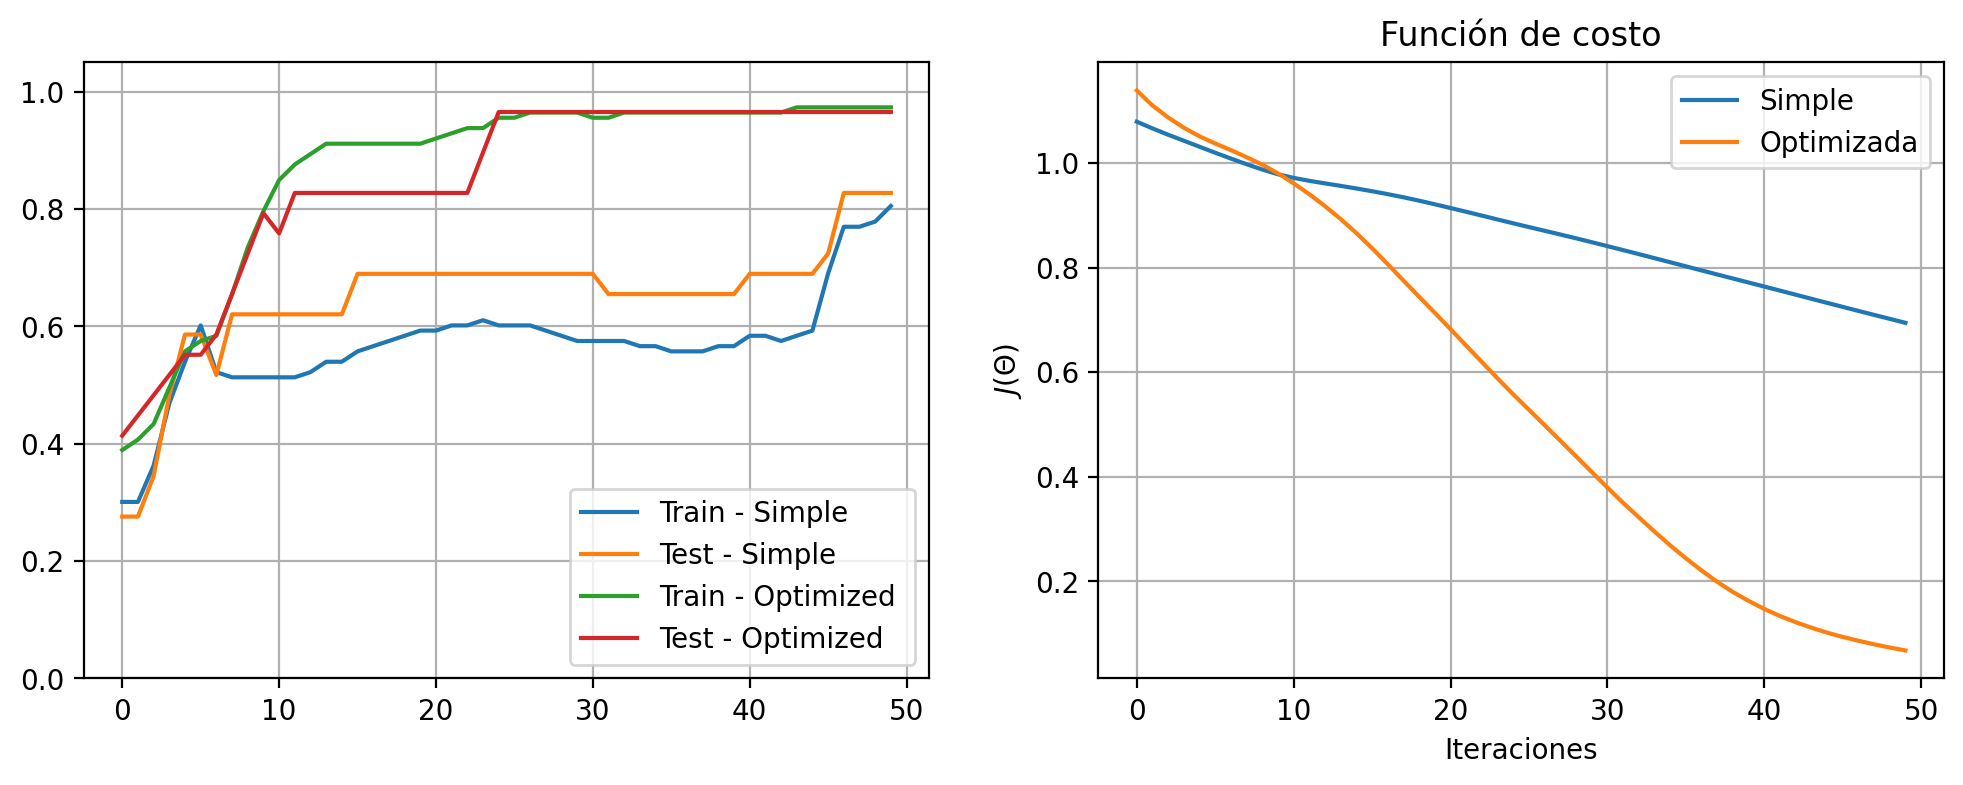

In [17]:
fig, axes = plt.subplots(1,2, figsize = (12,4))

axes[0].plot(simpleTrainScore, label = "Train - Simple ")
axes[0].plot(simpleValidateScore, label = "Test - Simple")
axes[0].plot(optimizedTrainScore, label = "Train - Optimized ")
axes[0].plot(optimizedValidateScore, label = "Test - Optimized")
axes[0].set_ylim([0, 1.05])
axes[0].grid(True)
axes[0].legend()

axes[1].plot(simpleNN.loss_curve_, label = "Simple")
axes[1].plot(optimizedNN.loss_curve_, label = "Optimizada")
axes[1].set_title("Función de costo")
axes[1].set_xlabel("Iteraciones")
axes[1].set_ylabel(r"$J(\Theta)$")
axes[1].legend()
axes[1].grid(True)

plt.show()

## Classification Metrics

In [18]:
print(classification_report(y_validate, simpleNN.predict(x_validate), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       0.90      1.00      0.95         9
      Wine B       0.77      0.83      0.80        12
      Wine C       0.83      0.62      0.71         8

    accuracy                           0.83        29
   macro avg       0.83      0.82      0.82        29
weighted avg       0.83      0.83      0.82        29



In [19]:
print(classification_report(y_validate, optimizedNN.predict(x_validate), target_names=["Wine A", "Wine B", "Wine C"]))

              precision    recall  f1-score   support

      Wine A       1.00      1.00      1.00         9
      Wine B       1.00      0.92      0.96        12
      Wine C       0.89      1.00      0.94         8

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.97        29
weighted avg       0.97      0.97      0.97        29



## Confusion Matrices

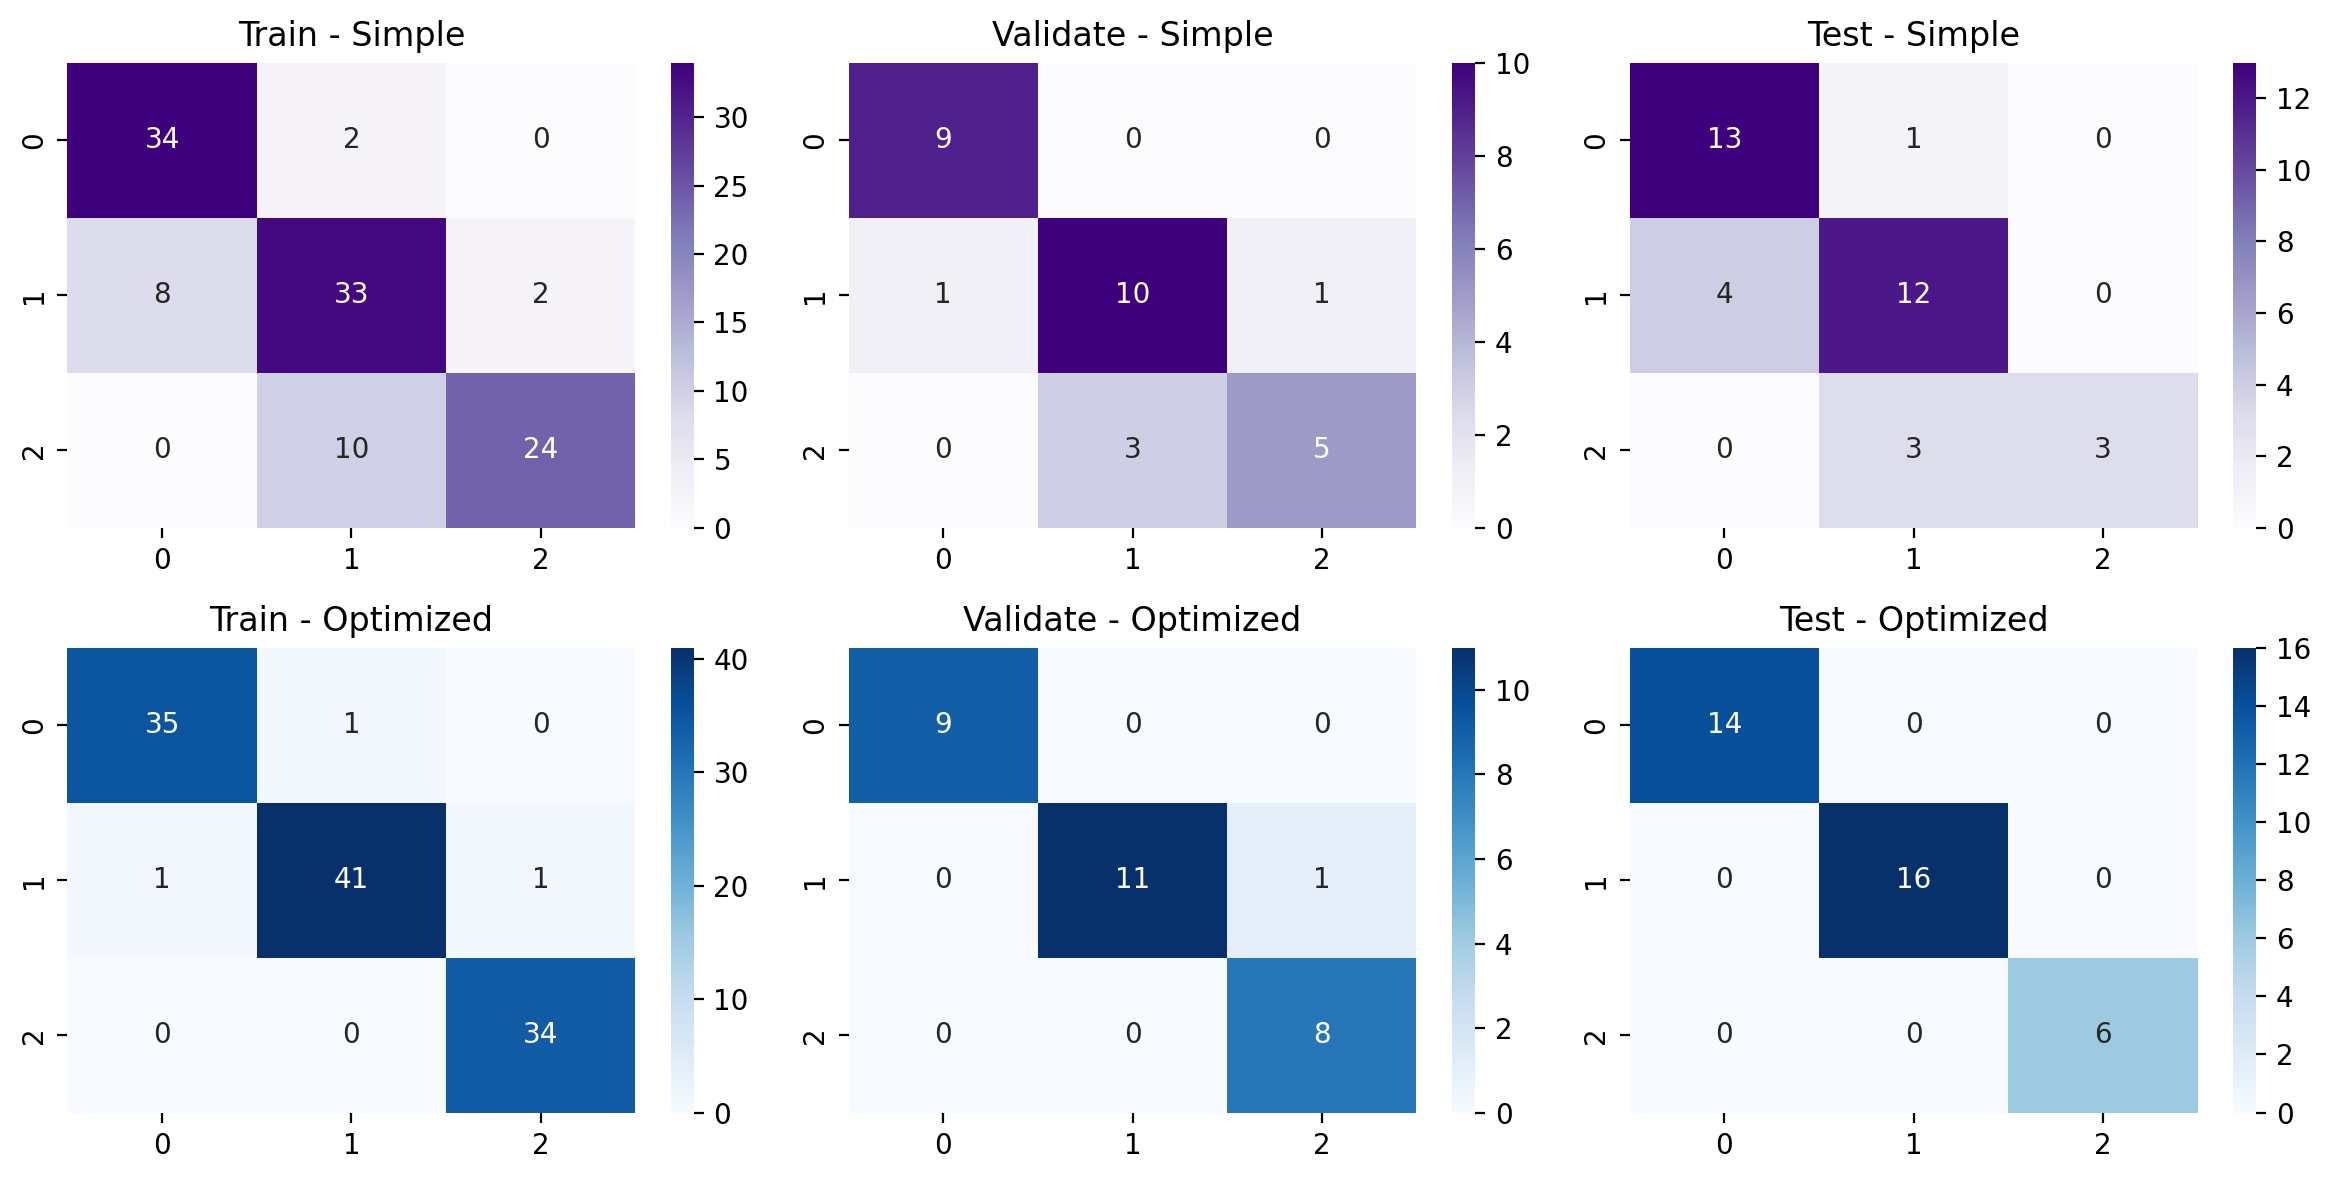

In [20]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))

sns.heatmap(confusion_matrix(y_train, simpleNN.predict(x_train)), annot = True, cmap = "Purples", ax = axes[0,0])
axes[0,0].set_title("Train - Simple")

sns.heatmap(confusion_matrix(y_validate, simpleNN.predict(x_validate)), annot = True, cmap = "Purples", ax = axes[0,1])
axes[0,1].set_title("Validate - Simple")

sns.heatmap(confusion_matrix(y_test, simpleNN.predict(x_test)), annot = True, cmap = "Purples", ax = axes[0,2])
axes[0,2].set_title("Test - Simple")

sns.heatmap(confusion_matrix(y_train, optimizedNN.predict(x_train)), annot = True, cmap = "Blues", ax = axes[1,0])
axes[1,0].set_title("Train - Optimized")

sns.heatmap(confusion_matrix(y_validate, optimizedNN.predict(x_validate)), annot = True, cmap = "Blues", ax = axes[1,1])
axes[1,1].set_title("Validate - Optimized")

sns.heatmap(confusion_matrix(y_test, optimizedNN.predict(x_test)), annot = True, cmap = "Blues", ax = axes[1,2])
axes[1,2].set_title("Test - Optimized")

plt.tight_layout()
plt.show()

## Performance as a function of train-test split

### Proportion of splits

In [21]:
train_score, test_score = [], []

PS = np.linspace(0.01, 0.99, epochs)

for ps in PS:
    
    x1, x_test, y1, y_test = train_test_split(x, y, train_size = ps, random_state = rsData)
    
    optimizedNN.fit(x_train, y_train);
    
    train_score.append(optimizedNN.score(x_train, y_train))
    test_score.append(optimizedNN.score(x_test, y_test))

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  war

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  war

Training score:  0.9734513274336284
Testing score:  0.9848070975816373


C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
print("Training score: ", np.array(train_score).mean())
print("Testing score: ", np.array(test_score).mean())

Training score:  0.9734513274336284
Testing score:  0.9848070975816373


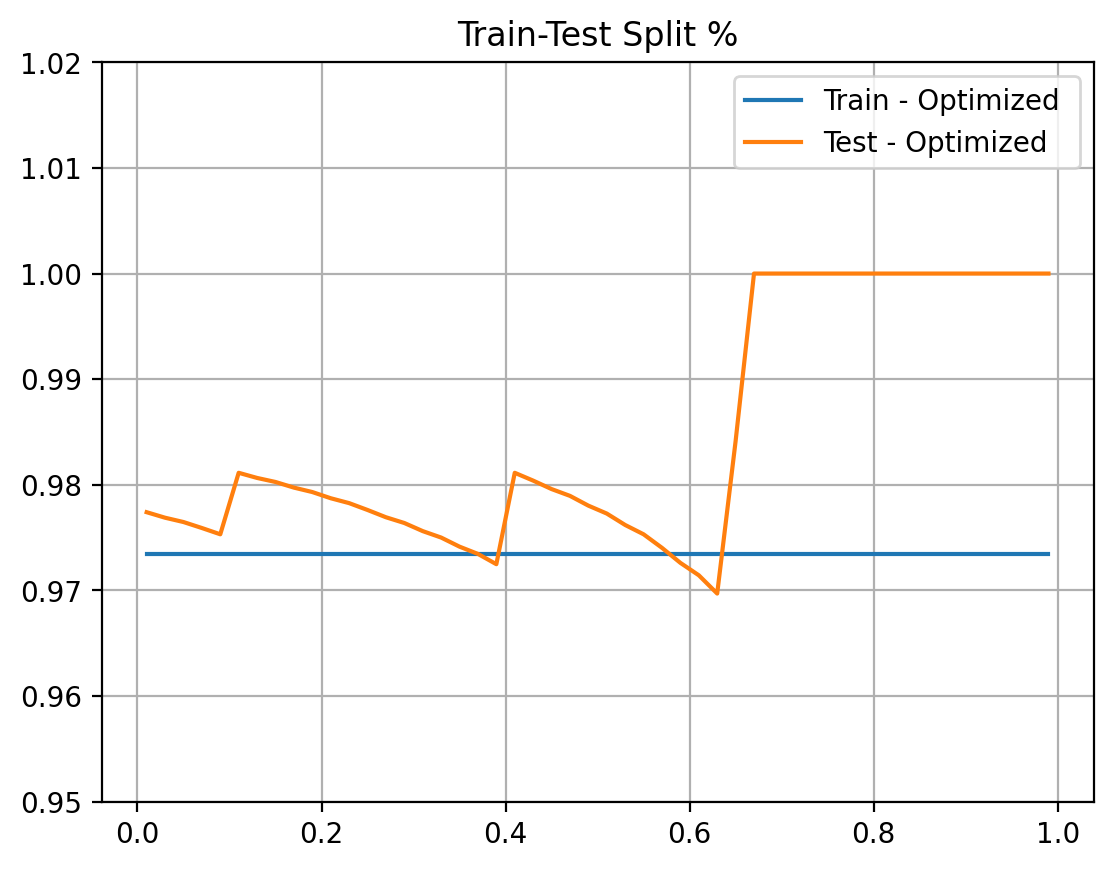

In [22]:
plt.plot(PS, train_score, label = "Train - Optimized ")
plt.plot(PS, test_score, label = "Test - Optimized")
plt.title("Train-Test Split %")
plt.ylim([0.95, 1.02])
plt.grid(True)
plt.legend()
plt.show()

### Random State

In [23]:
train_score_rs, test_score_rs = [], []

for i in range(epochs):
    
    x1, x_test, y1, y_test = train_test_split(x, y, train_size = 0.7, random_state = i)
    
    optimizedNN.fit(x_train, y_train);
    
    train_score_rs.append(optimizedNN.score(x_train, y_train))
    test_score_rs.append(optimizedNN.score(x_test, y_test))

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  war

C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Cristofer Becerra S\pyproject\Jupyter\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  war

In [24]:
print("Training score: ", np.array(train_score_rs).mean())
print("Testing score: ", np.array(test_score_rs).mean())

Training score:  0.9734513274336284
Testing score:  0.9811111111111112


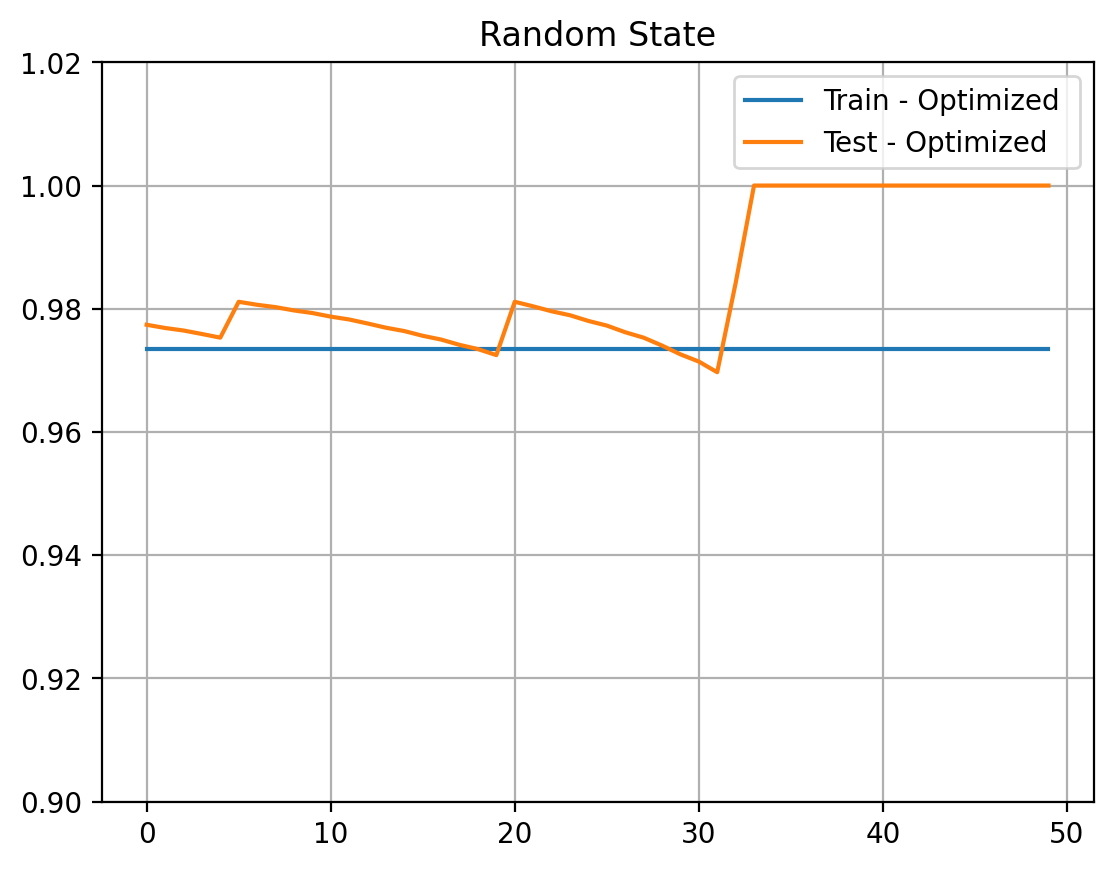

In [25]:
plt.plot(train_score, label = "Train - Optimized ")
plt.plot(test_score, label = "Test - Optimized")
plt.title("Random State")
plt.ylim([0.9, 1.02])
plt.grid(True)
plt.legend()
plt.show()

## Overfitting Analysis/Solution

In [26]:
# optimizedNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (8,8,16), learning_rate = "adaptive", 
#                             alpha = 0.01, learning_rate_init = 0.01, max_iter = 110)

# optimizedNN.fit(x_train, y_train)

# print("Training score: ", optimizedNN.score(x_train, y_train))
# print("Validate score: ", optimizedNN.score(x_validate, y_validate))
# print("Testing score: ", optimizedNN.score(x_test, y_test))

In [27]:
# Less overfitting
# optimizedNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (12,), solver = "adam", 
#                              activation = "relu", learning_rate = "adaptive", max_iter = 500)

# Fastest convergence
# optimizedNN = MLPClassifier(random_state = rs, hidden_layer_sizes = (2,), solver = "lbfgs", 
#                              activation = "relu", alpha = 0.001, learning_rate = "adaptive", 
#                              learning_rate_init = 0.0001, max_iter = 500)

# print("Training score: ", optimizedNN.score(x_train, y_train))
# print("Testing score: ", optimizedNN.score(x_test, y_test))